# Tutorial # 1 -- RT through a homogeneous, static sphere

In this first tutorial, we compute RT of radiation emitted by a central source through a homogeneous sphere filled with gas (and no dust initially). 

Before running anything, compile the code by typing `make` in the local (`tutorial_1`) directory. This will compile the RASCAS codes using the local `module_idealised_model.f90` code which implements the homogeneous, static sphere. 

# Setup and imports 

In [1]:
RascasDir       = '../../../'  # path to the rascas directory (could be an absolute path).
atomic_data_dir = '%s/ions_parameters/'%(RascasDir)  # path to the rascas/ions_parameters directory.
ExperimentDir   = './'  # where the RASCAS run will happen (and where param file will be written). 

# use a parallel environment or not
useMPI = True

# rascas
import sys
sys.path.append("%s/py/"%(RascasDir))
import write_param_files as wpf
import jphot as jp
import lya_utils as lya

# various things 
import os
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from astropy.constants import c

# 1. Definition of parameters

## 1.1. Model parameters 

### 1.1.1. Gas properties 

In [2]:
# Physical properties of the sphere 
ColumnDensity_cgs     = 1e15 # Column density of scatterers from center to border of sphere. [cm^-2]
Temperature           = 1e4  # temperature of the gas. [K]
TurbulentVelocity_kms = 10.0 # turbulent velocity of the gas. [km/s]

# Geometrical parameters 
boxsize_cm            = 1e20 # [cm]. This could be anything, really... 
Radius_boxUnits       = 0.4  # Radius of sphere in units of box-size 
                             # (0.5 means the sphere extends all the way to the edge).

# We should also specify the number and nature of the scatterer(s) (i.e. of the absorption line(s))
nscatterer = 2
scatterer_names = 'SiII-1190, SiII-1193'

### 1.1.2. Properties of the radiation source 

NB: radiation is emitted from a point source at rest at the center of the computational box.

In [3]:
# Definition of the spectral shape
spec_type            = 'PowLaw'   # We emit a power-law 
spec_powlaw_lmin_Ang = 1189       # from lambda = spec_powlaw_lmin_Ang   [Angstrom]
spec_powlaw_lmax_Ang = 1198       # to lambda = spec_powlaw_lmax_Ang     [Angstrom]
spec_powlaw_beta     = -2.0       # with slope spec_powlaw_beta (-2 means flat in F_lambda)

# Number of photon packets for the Monte Carlo experiment 
nPhotonPackets       = 100000


### 1.1.3. Numerical parameters 
These define how we will generate an adaptive mesh etc. 

In [4]:
refine_lmax        = 7       # no need for refinement with a homogeneous medium ... 
refine_err_grad_d  = 0.1   # will trigger refinement on density fluctuations (if above 10% level)

### 1.1.4. Parameters for mocks (with peeling off)

In [5]:
# Here we need to specify the properties of the mocks we wish to construct, in terms of aim (coords 
# of target and direction of observation) and in terms of observation (photometry, spectroscopy, 
# imaging, 3D spectroscopy). This is done through parameters which need to be written to a file. 

# We start by setting up one pointing and defining the observations for it. 
target_position = np.array([0.5,0.5,0.5])  # aim for the center of the box (all in box units here... )
kobs = np.array([0,1,0])  # observe along the y direction (make sure k is normalised)

# now, let's add a spectroscopic observation
npix = 200 # the nb of wavelength bins
aperture = 1. # the radius of the circular aperture within which photon packets are collected (in box-size units)
lambda_min = 1189  # min wavelength (Angstrom)
lambda_max = 1198  # max wavelength (Angstrom)
spec = wpf.specParams(npix,aperture,lambda_min,lambda_max)

# let's make an image as well ... 
npix = 200 # nb of pixels on a side
size = 1.   # size of the image (side)
image = wpf.imageParams(npix,size)

# define the object containing all the above information
p = wpf.pointing(kobs,target_position,spec=spec,image=image)

# and write it into some file 
mock_params_file = '%s/mock_param_file.txt'%ExperimentDir
f = open(mock_params_file,'w')
p.write(f)
f.close()

## 1.2. Setting up the parameter file

In [6]:
Parameters = []  # initialise a list of parameter sections

### GEOMETRY 
section = 'GenerateAMRmodel'
params = {
    'DomDumpDir'       : ExperimentDir,
    'comput_dom_type'  : 'sphere',
    'comput_dom_pos'   : '0.5,0.5,0.5',
    'comput_dom_rsp'   : '%f'%(Radius_boxUnits)
}
Parameters.append(wpf.param_section(section,params))


### MESH
section = 'mesh'
params = {
    'verbose'       : 'F',
    'refine_lmax'   : '%i'%(refine_lmax),   
    'refine_err_grad_d'  : '%.2f'%(refine_err_grad_d),
    'refine_err_grad_v'  : '-1',  
    'refine_dv_over_vth' : 'F',
}
Parameters.append(wpf.param_section(section,params))


### GAS COMPOSITION 
section = 'gas_composition'
params = {
    'nscatterer'       : '%i'%(nscatterer), 
    'scatterer_names'  : scatterer_names,
    'atomic_data_dir'   : atomic_data_dir,
    'ignoreDust': 'T'
}
Parameters.append(wpf.param_section(section,params))


### DUST (unused initially ... )
section = 'dust'
params = {
    'albedo':0.32,
    'g_dust':0.73,
    'dust_model':'SMC'
}
Parameters.append(wpf.param_section(section,params))


### IDEALISED MODEL
section = 'IdealisedModel'
params ={
    'ColumnDensity_cgs': '%e'%(ColumnDensity_cgs),
    'boxsize_cm': '%e'%(boxsize_cm),
    'Radius_boxUnits': '%e'%(Radius_boxUnits),
    'Temperature':'%e'%(Temperature),
    'TurbulentVelocity_kms':'%f'%(TurbulentVelocity_kms)
}
Parameters.append(wpf.param_section(section,params))


### SOURCE MODEL 
section = 'PhotonsFromSourceModel'
params ={
    'outputfile' : '%s/ppic.dat'%ExperimentDir,
    'source_pos' : '0.5,0.5,0.5',
    'source_vel' : '0,0,0',        # cm/s
    'source_type': 'pointlike',
    'spec_type'  : spec_type,
    'spec_powlaw_lmin_Ang' : '%f'%(spec_powlaw_lmin_Ang),
    'spec_powlaw_lmax_Ang' : '%f'%(spec_powlaw_lmax_Ang),
    'spec_powlaw_beta'     : '%f'%(spec_powlaw_beta),
    'nPhotonPackets'       : '%i'%(nPhotonPackets)
}
Parameters.append(wpf.param_section(section,params))


# RASCAS
if useMPI:
    section = 'rascas' 
else:
    section = 'rascas-serial' 
nbundle = min(nPhotonPackets/100,1000)
params ={
    'verbose':'T',
    'DomDumpDir':ExperimentDir,
    'PhotonICFile':'%s/ppic.dat'%ExperimentDir,
    'fileout':'%s/result.dat'%ExperimentDir,
    'nbundle':'%i'%nbundle
}
Parameters.append(wpf.param_section(section,params))


## WORKER (if MPI)
if useMPI:
    section='worker'
    params={'verbose':'T'}
    Parameters.append(wpf.param_section(section,params))
    

### MOCK -- peeling off
section='mock'
params = {
    'nDirections':'1', 
    'mock_parameter_file':'%s'%mock_params_file,
    'mock_outputfilename':'%s/mock'%ExperimentDir
}
Parameters.append(wpf.param_section(section,params))


#### write parameter list to a file 
wpf.write_parameter_file('%s/params.cfg'%(ExperimentDir),Parameters)

# 2.  Run the codes

## 2.1 create mesh and visualize it

Execute the following cell in order run the executable `GenerateAMRmodel` which generates the adaptive mesh containing the model. This will generate a few files in the `ExperimentDir`, including a log file `GenerateAMRmodel.log`, the `.mesh` file (which has the data) and some `.dom` files which describe different domains. 

In [8]:
# run GenerateAMRmodel
cmd = "./GenerateAMRmodel params.cfg > GenerateAMRmodel.log"
error = os.system(cmd)
if error != 0:
    print('Something went wrong...')
    print('-> check file GenerateAMRmodel.log or message below for more info')

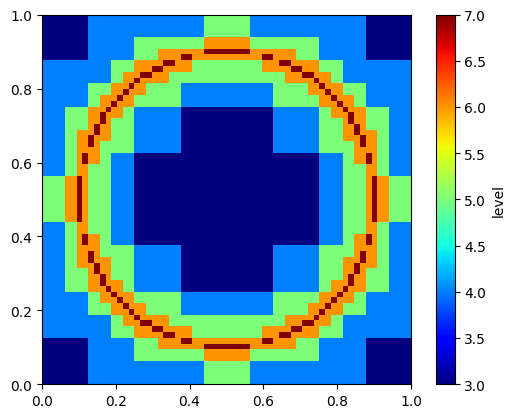

In [9]:
# visualise the mesh

# Short note:
# AMR mesh means that cells have different sizes. Here, we want to visualise the size of the cells. 
# We will make a map of the maximum level of refinement of the cells along the line-of-sight. 
# (Higher refinement level means more resolved, so smallest cells.)
# To better see how resolution changes with radius in the case of the sphere, 
# we will make a map by selecting only cells in a thin slice along the line-of-sight.

import maps as ma
import mesh as me

# read the mesh file
mdom = me.mesh(filename="domain_1.mesh",gasmix="new_ions")

lmax = np.amax(mdom.gas.leaflevel)
levels = np.array(mdom.gas.leaflevel[:])
positions = mdom.gas.xleaf

# make a map of the maximum level of refinement of the mesh
map, _ = ma.lmax_map(lmax,positions,levels,0.,1.,0.499,0.501,0.,1.,'y')

im = plt.imshow(map,interpolation='nearest',origin='lower',
                    extent=(0.,1.,0.,1.),
                    cmap='jet')
cbar = plt.colorbar(im)
cbar.set_label(r'level')
plt.show()

/var/folders/0w/jfnq_y_17v12gyvqgk25jkh80000gn/T/ipykernel_35646/1006784969.py:19: RuntimeWarning: invalid value encountered in divide
  im = plt.imshow(map/weight,interpolation='nearest',origin='lower',


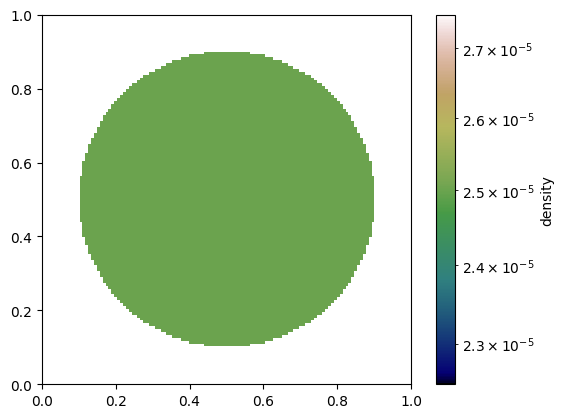

In [10]:
# make a density map
positions = mdom.gas.xleaf
density = np.array(mdom.gas.nion)

# select only cells with non-zero density
ii = density > 0
pos = np.array((positions[0,:][ii],positions[1,:][ii],positions[2,:][ii]))
lev = levels[ii]
dens = density[ii]

map, _ = ma.make_map(lmax,pos,lev,dens,0.,1.,0.,1.,0.,1.,'z')

#nleaf = mdom.nleaf
#deno = np.ones(nleaf)
deno = np.ones(dens.shape)
weight, _ = ma.make_map(lmax,pos,lev,deno,0.,1.,0.,1.,0.,1.,'z')

from matplotlib.colors import LogNorm
im = plt.imshow(map/weight,interpolation='nearest',origin='lower',
                    norm=LogNorm(),
                    extent=(0.,1.,0.,1.),
                    cmap='gist_earth')

cbar = plt.colorbar(im)
cbar.set_label(r'density')
plt.show()

## 2.2 create the photon packets

Execute the following cell in order run the executable `PhotonsFromSourceModel` which generates the initial conditions for photon packets. This will generate a couple files in the `ExperimentDir`: a log file `PhotonsFromSourceModel.log` and the `ppic.dat` file (which has the data). 

In [11]:
# run PhotonsFromSourceModel
cmd = "./PhotonsFromSourceModel params.cfg > PhotonsFromSourceModel.log"
error = os.system(cmd)
if error != 0:
    print('Something went wrong...')
    print('-> check file PhotonsFromSourceModel.log or message below for more info')

## 2.3 Run the radiative transfer

Execute the following cell in order run radiative transfer computation with `rascas` (or `rascas-serial` if you do not have MPI). This may take time depending on the experiment. If it is too slow, reduce the number of photon packets above. 

In [12]:
# run RASCAS 
if useMPI:
    cmd = "time mpirun ./rascas params.cfg > rascas.log"
else:
    cmd = "time ./rascas-serial params.cfg > rascas.log"
error = os.system(cmd)
if error != 0:
    print('Something went wrong...')
    print('-> check file rascas.log or message below for more info')

--------------------------------------------------------------------------
A system call failed during shared memory initialization that should
not have.  It is likely that your MPI job will now either abort or
experience performance degradation.

  Local host:  lmdbook-ecran.univ-lyon1.fr
  System call: unlink(2) /var/folders/0w/jfnq_y_17v12gyvqgk25jkh80000gn/T//ompi.lmdbook-ecran.501/pid.37534/1/vader_segment.lmdbook-ecran.501.9e620001.7
  Error:       No such file or directory (errno 2)
--------------------------------------------------------------------------
[lmdbook-ecran.univ-lyon1.fr:37534] 1 more process has sent help message help-opal-shmem-mmap.txt / sys call fail
[lmdbook-ecran.univ-lyon1.fr:37534] Set MCA parameter "orte_base_help_aggregate" to 0 to see all help / error messages

real	0m1.557s
user	0m2.730s
sys	0m0.389s


# 3. Plot the results 

## 3.1. results from photon packets

In [13]:
# load the results of the RASCAS experiment
p = jp.photonlist('ppic.dat','result.dat')

### 3.1.1. Spectrum (angle-averaged and spatially integrated)

In [14]:
# get the observed spectrum
lobs,sobs = p.spectrum(frame='obs',nbins=200)

# get the intrinsic spectrum
lint,sint = p.spectrum(frame='ic',nbins=200)

In [15]:
# normalise spectra to the median value of the intrinsic spectrum (i.e. the continuum level)
continuum = np.median(sint)
sobs = sobs / continuum
sint = sint / continuum

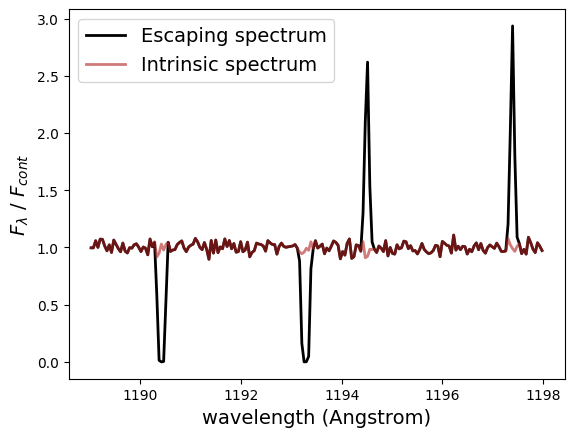

In [16]:
# plot spectra 
plt.plot(lobs,sobs,label='Escaping spectrum',lw=2,ls='-',c='k')
plt.plot(lint,sint,alpha=0.6,label='Intrinsic spectrum',lw=2,ls='-',c='firebrick')
plt.legend(fontsize=14)
plt.xlabel('wavelength (Angstrom)',fontsize=14)
plt.ylabel(r'$F_\lambda\ /\ F_{cont}$',fontsize=14)
plt.show()

### 3.1.2. Surface-brightness map and profile (angle-averaged)

In [17]:
# compute projected distance of each photon packet to the source, in the plane perpendicular 
# to the photon packet's propagation direction. 
# (NB:Source is located at 0.5,0.5,0.5, i.e. center of the box.)
rp = p.projected_radius(xc=0.5,yc=0.5,zc=0.5)

/Users/leo/astrophysics/rascas_devs/dev_2023-07_mergeSaasFee/rascas/tutorials/tutorial_1/../..//py/jphot.py:275: RuntimeWarning: invalid value encountered in divide
  ux       = np.nan_to_num((self.x-xc)/unorm)
/Users/leo/astrophysics/rascas_devs/dev_2023-07_mergeSaasFee/rascas/tutorials/tutorial_1/../..//py/jphot.py:276: RuntimeWarning: invalid value encountered in divide
  uy       = np.nan_to_num((self.y-yc)/unorm)
/Users/leo/astrophysics/rascas_devs/dev_2023-07_mergeSaasFee/rascas/tutorials/tutorial_1/../..//py/jphot.py:277: RuntimeWarning: invalid value encountered in divide
  uz       = np.nan_to_num((self.z-zc)/unorm)


In [18]:
# compute SB profile in arbitrary units (number of photon packets per annulus area, in box units)
h,edges = np.histogram(rp,bins=100)
bin_centers = 0.5*(edges[:-1]+edges[1:])
dr = bin_centers[1]-bin_centers[0]
h = h / (2.*np.pi*bin_centers*dr)   # SB profile, arbitrary units

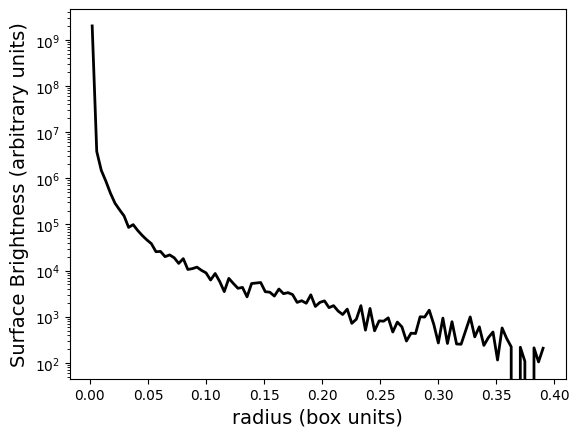

In [19]:
# plot SB profile
plt.plot(bin_centers,h, lw=2,ls='-',c='k')
plt.yscale('log')
plt.xlabel('radius (box units)',fontsize=14)
plt.ylabel('Surface Brightness (arbitrary units)',fontsize=14)
plt.show()

### 3.1.3. Spatially resolved spectrum (angle-averaged)

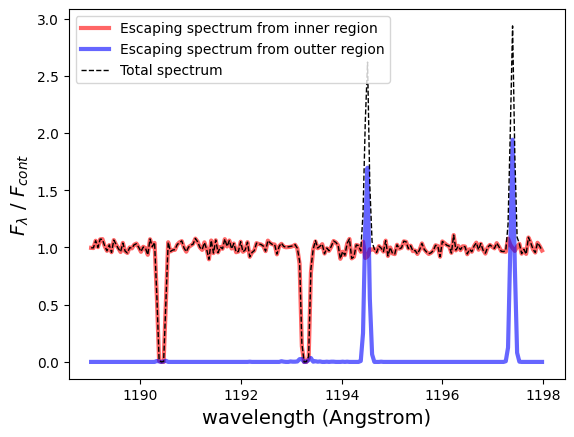

In [20]:
# select and extract photon packets escaping from the inner region (point source -> take really small radius)
iiIN = np.where(rp < 1e-5)
pIN  = p.extract_sample(iiIN)
lIN,sIN = pIN.spectrum(frame='obs',nbins=200,lmin=spec_powlaw_lmin_Ang,lmax=spec_powlaw_lmax_Ang)
sIN /= continuum
plt.plot(lIN,sIN,alpha=0.6,label='Escaping spectrum from inner region',lw=3,ls='-',c='r')

# select and extract photon packets escaping from the outter region 
iiIN = np.where(rp >= 1e-5)
pIN  = p.extract_sample(iiIN)
lIN,sIN = pIN.spectrum(frame='obs',nbins=200,lmin=spec_powlaw_lmin_Ang,lmax=spec_powlaw_lmax_Ang)
sIN /= continuum
plt.plot(lIN,sIN,alpha=0.6,label='Escaping spectrum from outter region',lw=3,ls='-',c='b')

# plot total as well 
plt.plot(lobs,sobs,label='Total spectrum',lw=1,ls='--',c='k')

plt.xlabel('wavelength (Angstrom)',fontsize=14)
plt.ylabel(r'$F_\lambda\ /\ F_{cont}$',fontsize=14)
plt.legend()
plt.show()

## 3.2. Peeling off results 

In [21]:
from mocks import mockobs
m = mockobs('./','mock','./ppic.dat',load_spectrum=True,load_image=True)

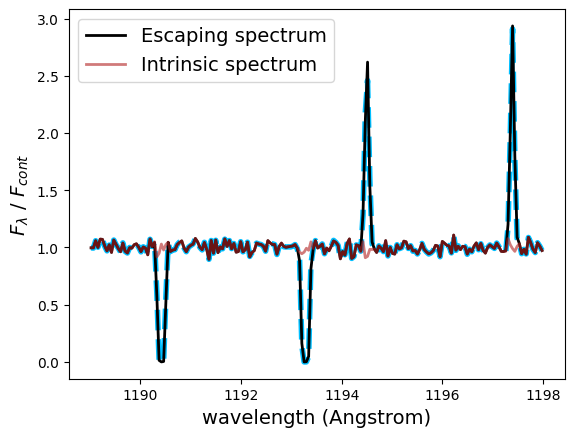

In [22]:
plt.figure()
plt.plot(m.spec_lbda_Angstrom,m.spec/continuum,lw=4,ls='--',c='deepskyblue')
plt.plot(lobs,sobs,label='Escaping spectrum',lw=2,ls='-',c='k')
plt.plot(lint,sint,alpha=0.6,label='Intrinsic spectrum',lw=2,ls='-',c='firebrick')
plt.legend(fontsize=14)
plt.xlabel('wavelength (Angstrom)',fontsize=14)
plt.ylabel(r'$F_\lambda\ /\ F_{cont}$',fontsize=14)
plt.show()

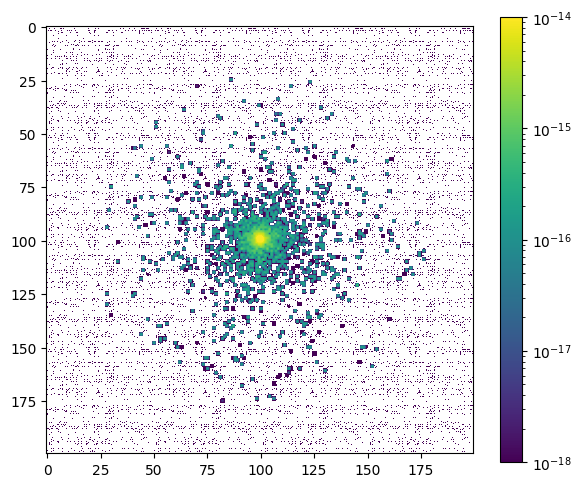

In [23]:
m.show_image(smooth=False,vmin=1e-18,vmax=1e-14) 